In [1]:
import tensorflow as tf
import numpy as np
from nbutil import imshow_multi
import os
from tensorflow.contrib.layers.python.layers import batch_norm
from tensorflow.contrib.layers import xavier_initializer
from PIL import Image
import urllib, cStringIO
import cv2

In [2]:
BATCH_SIZE = 16


In [3]:
attr_file = '../data/celeba/list_attr_celeba.txt'
keys = None
attributes_by_image = {}
for i, line in enumerate(open(attr_file)):
    if i == 1:
        keys = line.split()
    elif i > 1:
        image = os.path.join('../data/celeba/img_align_celeba', line.split()[0])
        values = line.split()[1:]
        attributes_by_image[image] = {attr: val == '1' for attr, val in zip(keys, values)}


In [4]:
image_names = attributes_by_image.keys()
attr_vector = np.zeros((len(attributes_by_image), len(keys)))
for i, image_name in enumerate(image_names):
    attrs = attributes_by_image[image_name]
    attr_vector[i] = [(1 if attrs[key] else 0) for key in keys]


In [5]:
# filename_queue = tf.train.string_input_producer(image_names, num_epochs=None)
# attr_queue = tf.train.input_producer(tf.constant(attr_vector), num_epochs=None)

def create_qs(train):
    filename_tensor = tf.convert_to_tensor(image_names, dtype=tf.string)
    attr_tensor = tf.convert_to_tensor(attr_vector, dtype=tf.float32)
    filename_q, attr_q = tf.train.slice_input_producer([filename_tensor, attr_tensor], num_epochs=None, shuffle=True)

    # reader = tf.WholeFileReader()
    # filename, image_data = reader.read(filename_q)
    image_255 = tf.image.decode_jpeg(tf.read_file(filename_q))
    image = tf.reshape(tf.cast(image_255, tf.float32) / 255.0, [218, 178, 3]) # images are 178x218
    # image = tf.image.rgb_to_grayscale(image)

    def resize_image(image):
        # image = tf.random_crop(image, [192, 160, 3])
        # return image
        image = tf.image.resize_image_with_crop_or_pad(image, 160, 160)
        img_reshaped = tf.reshape(image, [1, 160, 160, 3])
        image = tf.image.resize_bilinear(img_reshaped, [64, 64])
        return tf.reshape(image, [64, 64, 3])
    image = resize_image(image)

    def distort_image(image):
        # noise_amt = tf.abs(tf.random_normal([], stddev=0.2))
        # distorted_image = image + tf.random_uniform([64, 64, 3], maxval=noise_amt)
        distorted_image = tf.image.random_flip_left_right(image)
        distorted_image = tf.image.random_brightness(distorted_image, max_delta=0.3)
        distorted_image = tf.image.random_contrast(distorted_image, lower=0.6, upper=1.6)
        # distorted_image = tf.image.per_image_standardization(distorted_image)
        # distorted_image = tf.clip_by_value(distorted_image, 0, 1)
        return distorted_image

    images_batch, attrs_batch = tf.train.shuffle_batch([distort_image(image), attr_q], batch_size=BATCH_SIZE, capacity=BATCH_SIZE*20, min_after_dequeue=BATCH_SIZE*10)
    return images_batch, attrs_batch

images_batch, attrs_batch = create_qs(True)


In [6]:
session = tf.InteractiveSession()
init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
session.run(init_op)
tf.train.start_queue_runners(sess=session)

[<Thread(Thread-13, started daemon 139921863079680)>,
 <Thread(Thread-14, started daemon 139921377457920)>]

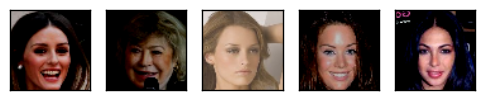

In [7]:
%matplotlib inline

images_, attrs_ = session.run([images_batch, attrs_batch])

imshow_multi(images_[:5])

In [8]:
keys

['5_o_Clock_Shadow',
 'Arched_Eyebrows',
 'Attractive',
 'Bags_Under_Eyes',
 'Bald',
 'Bangs',
 'Big_Lips',
 'Big_Nose',
 'Black_Hair',
 'Blond_Hair',
 'Blurry',
 'Brown_Hair',
 'Bushy_Eyebrows',
 'Chubby',
 'Double_Chin',
 'Eyeglasses',
 'Goatee',
 'Gray_Hair',
 'Heavy_Makeup',
 'High_Cheekbones',
 'Male',
 'Mouth_Slightly_Open',
 'Mustache',
 'Narrow_Eyes',
 'No_Beard',
 'Oval_Face',
 'Pale_Skin',
 'Pointy_Nose',
 'Receding_Hairline',
 'Rosy_Cheeks',
 'Sideburns',
 'Smiling',
 'Straight_Hair',
 'Wavy_Hair',
 'Wearing_Earrings',
 'Wearing_Hat',
 'Wearing_Lipstick',
 'Wearing_Necklace',
 'Wearing_Necktie',
 'Young']

In [9]:
disc_dropout_keep_prob = tf.placeholder_with_default(tf.constant(1.0), [], name='disc_dropout_keep_prob')        
gen_dropout_keep_prob = tf.placeholder_with_default(tf.constant(0.75), [], name='gen_dropout_keep_prob')

def lrelu(x):
    alpha = 0.1
    return tf.maximum(alpha*x, x)

relu = tf.nn.relu

def concat_elu(x):
    """ like concatenated ReLU (http://arxiv.org/abs/1603.05201), but then with ELU """
    axis = len(x.get_shape())-1
    return tf.nn.elu(tf.concat(axis, [x, -x]))

def concat_lrelu(x):
    axis = len(x.get_shape())-1
    return lrelu(tf.concat(axis, [x, -x]))

def concat_relu(x):
    axis = len(x.get_shape())-1
    return tf.nn.relu(tf.concat(axis, [x, -x]))

def create_batch_norm(inputs, name='bn'):
    with tf.variable_scope(name):
        return batch_norm(inputs, is_training=True, updates_collections=None, decay=0.9)

def create_disc_dropout(inputs):
    return tf.nn.dropout(inputs, disc_dropout_keep_prob)

def create_gen_dropout(inputs):
    return tf.nn.dropout(inputs, gen_dropout_keep_prob)

conv_init = tf.truncated_normal_initializer(0, 0.1)
bias_init = tf.truncated_normal_initializer(0.1, 0.0)

def create_max_pool(inputs, ksize=2, stride=2):
    return tf.nn.max_pool(inputs, ksize=[1, ksize, ksize, 1], strides=[1, stride, stride, 1], padding='SAME')

def create_avg_pool(inputs, ksize=2, stride=2):
    return tf.nn.avg_pool(inputs, ksize=[1, ksize, ksize, 1], strides=[1, stride, stride, 1], padding='SAME')

def create_conv(input, out_channels, patch_size=5, stride=1, name='conv'):
    with tf.variable_scope(name):
        in_channels = input.get_shape()[-1].value
        # w = weight_var([patch_size, patch_size, in_channels, out_channels], name='w', key=join_keys(key, 'w'))
        # b = weight_var([out_channels], stddev=0, name='b', mean=0.1, key=join_keys(key, 'b'))
        w = tf.get_variable('w', 
                            shape=[patch_size, patch_size, in_channels, out_channels], 
                            initializer=conv_init)
        b = tf.get_variable('b',
                           shape=[out_channels],
                           initializer=bias_init)
        conv = tf.nn.conv2d(input, w, strides=[1,stride,stride,1], padding='SAME')
        return conv+b

def create_deconv(input, out_channels, patch_size=5, stride=1, name='deconv'):
    with tf.variable_scope(name):
        # for best results, patch_size should be a multiple of stride
        input_w, input_h, input_channels = [i.value for i in input.get_shape()[-3:]]

        # w = weight_var([patch_size, patch_size, out_channels, input_channels])
        # b = weight_var([out_channels], mean=0.1)
        w = tf.get_variable('w', 
                            shape=[patch_size, patch_size, out_channels, input_channels], 
                            initializer=conv_init)
        b = tf.get_variable('b',
                            shape=[out_channels],
                            initializer=bias_init)

        batch_size = BATCH_SIZE # tf.shape(input)[0]
        output_shape = tf.pack([batch_size, input_w*stride, input_h*stride, out_channels])

        deconv = tf.nn.conv2d_transpose(input, w, output_shape, strides=[1,stride,stride,1], padding='SAME')

        return deconv + b

def create_fc(input, out_channels, name='fc'):
    with tf.variable_scope(name):
        in_channels = input.get_shape()[-1].value
        w = tf.get_variable('w', shape=[in_channels, out_channels], initializer=conv_init)
        b = tf.get_variable('b', shape=[out_channels], initializer=bias_init)
        return tf.matmul(input, w) + b

def create_similarity_loss(input, name='sl'):
    with tf.variable_scope(name):
        count = input.get_shape()[0].value
        offset_batch = tf.concat(0, [input[1:count], input[0:1]])
        diff = tf.abs(input - offset_batch)
        return -tf.reduce_mean(diff)

def create_inter_minibatch_layer(input, channels_to_add=4, name='ib1'):
    with tf.variable_scope(name):
        count = input.get_shape()[0].value
        offset_batch = tf.concat(0, [input[1:count], input[0:1]])
        diff = input - offset_batch
        filtered = create_conv(diff, channels_to_add, patch_size=1)
        return tf.concat(len(input.get_shape())-1, [input, filtered])
    

In [14]:
def generator(noise_vec, condition_vec, name='gen', reuse=False):
    with tf.variable_scope(name, reuse=reuse):
        vec = tf.concat(1, [noise_vec, tf.cast(condition_vec, tf.float32)])
        vec = tf.nn.relu(create_fc(vec, 512, name='fc1'))
        image = tf.reshape(vec, [-1, 4, 4, 32])
        layers = [32, 32, 32, 16]
        for i, channels in enumerate(layers):
                image = create_deconv(image, channels, patch_size=4, stride=2, name='deconv'+str(i))
                image = lrelu(image)
                image = create_batch_norm(image, name='bn'+str(i))
        image = create_conv(image, 3, 1, 1, name='color_conv')
        return tf.nn.tanh(image)

def critic(image, name='critic', reuse=False):
    with tf.variable_scope(name, reuse=reuse):
        layers = [16, 32, 64, 64]
        for i, channels in enumerate(layers):
            image = create_conv(image, channels, patch_size=5, stride=1, name='conv'+str(i))
            image = lrelu(image)
            image = create_avg_pool(image)
            # image = create_batch_norm(image, name='bn'+str(i))
            # image = create_disc_dropout(image)
        vec = tf.reshape(image, [-1, 4 * 4 * 64])
        vec = create_disc_dropout(vec)
        vec = lrelu(create_fc(vec, 256, name='fc0'))
        is_real = create_fc(vec, 2, name='fc_is_real')
        return is_real

scopename = 'wgan4'
with tf.variable_scope(scopename, reuse=False):
    gen_lr = tf.placeholder_with_default(tf.constant(5e-5), [], name='gen_lr')
    critic_lr = tf.placeholder_with_default(tf.constant(5e-5), [], name='critic_lr')
    
    attributes = ['Male', 'Smiling']
    attr_indices = [keys.index(attr) for attr in attributes]
    real_cond_vec = tf.transpose(tf.gather(tf.transpose(attrs_batch, [1, 0]), attr_indices), [1, 0])
    real_cond_vec = tf.cast(real_cond_vec, tf.int32)
        
    fake_cond_vec_target = tf.random_uniform([BATCH_SIZE, len(attributes)], minval=0, maxval=2, dtype=tf.int32)
    noise = tf.random_uniform([BATCH_SIZE, 128], minval=-1, maxval=1)
    generated_images = generator(noise, fake_cond_vec_target)
    
    # are_fakes_real = discriminator(generated_images)
    # are_reals_real = discriminator(images_batch, reuse=True)
    disc_input = tf.concat(0, [generated_images, images_batch])
    are_images_real = critic(disc_input)
    are_fakes_real = are_images_real[:BATCH_SIZE]
    are_reals_real = are_images_real[BATCH_SIZE:]
    
    gen_loss = -tf.reduce_mean(are_fakes_real)
    critic_loss = tf.reduce_mean(are_fakes_real) - tf.reduce_mean(are_reals_real)
    
    # cond_loss = compute_loss(gen_cond_pred, fake_cond_vec)
    
    # only increment the global step when training the generator:
    global_step = tf.contrib.framework.get_or_create_global_step()
    
    critic_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=scopename+'/critic')
    weight_clip_op = tf.group(*[w.assign(tf.clip_by_value(w, -0.01, 0.01)) for w in critic_vars])
    train_critic_op = tf.train.RMSPropOptimizer(critic_lr).minimize(critic_loss, var_list=critic_vars)
    train_critic = tf.group(weight_clip_op, train_critic_op)
    
    gen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=scopename+'/gen')
    train_gen = tf.train.RMSPropOptimizer(gen_lr).minimize(gen_loss, global_step=global_step, var_list=gen_vars)
    
    # examples = tf.image.grayscale_to_rgb(generated_images)
    examples = generated_images


In [15]:
session = None
saver = None
save_path = None

def create_session():
    global session
    global saver
    global save_path
    
    if session: session.close()
    
    session = tf.InteractiveSession()

    save_path = None # 'models/acgan3-4-no-classifier'
    
    init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
    session.run(init_op)
    tf.train.start_queue_runners(sess=session)

    import os
    saver = None
    if save_path:
        if not os.path.exists(save_path):
            os.mkdir(save_path)
        saver = tf.train.Saver()
        ckpt = tf.train.get_checkpoint_state(save_path)
        if ckpt and ckpt.model_checkpoint_path:
            saver.restore(session, ckpt.model_checkpoint_path)
            print 'Restored from checkpoint', ckpt.model_checkpoint_path
        else:
            print 'Did not restore from checkpoint'
    else:
        print 'Will not save progress'

create_session()

Will not save progress


Step: 8500, critic loss: -5.93708110222


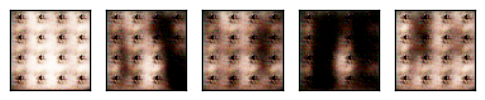

Step: 8520, critic loss: -5.7188038969
Step: 8540, critic loss: -5.61588405609
Step: 8560, critic loss: -5.60883827686
Step: 8580, critic loss: -5.87129419565
Step: 8600, critic loss: -5.81119008541


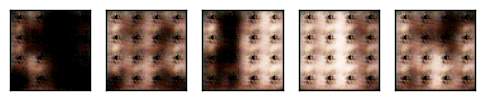

Step: 8620, critic loss: -5.78929988384
Step: 8640, critic loss: -5.74651752472
Step: 8660, critic loss: -5.73677263737
Step: 8680, critic loss: -5.80145675659
Step: 8700, critic loss: -5.76926937103


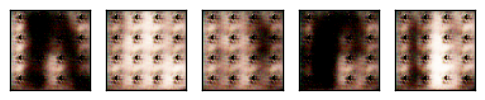

Step: 8720, critic loss: -5.74137285709
Step: 8740, critic loss: -5.77378934383
Step: 8760, critic loss: -5.75340633869
Step: 8780, critic loss: -5.68583459854
Step: 8800, critic loss: -5.73524660587


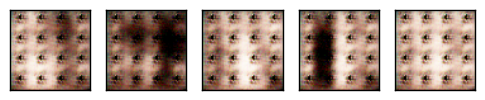

Step: 8820, critic loss: -5.71551319122
Step: 8840, critic loss: -5.75881763458
Step: 8860, critic loss: -5.84922312737
Step: 8880, critic loss: -5.70895945072
Step: 8900, critic loss: -5.77868787289


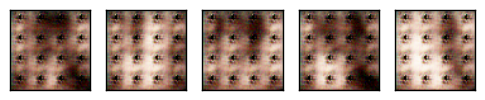

Step: 8920, critic loss: -5.78052742481
Step: 8940, critic loss: -5.91493329287
Step: 8960, critic loss: -5.83702002764
Step: 8980, critic loss: -5.88283761978
Step: 9000, critic loss: -5.761855642


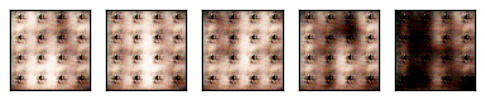

Step: 9020, critic loss: -5.81791737556
Step: 9040, critic loss: -5.72201530457
Step: 9060, critic loss: -5.77293390751
Step: 9080, critic loss: -5.54686302662
Step: 9100, critic loss: -5.71287679195


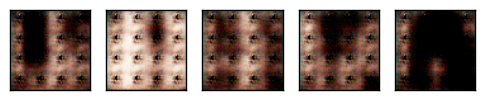

Step: 9120, critic loss: -5.66723408222
Step: 9140, critic loss: -5.85781771183
Step: 9160, critic loss: -5.77787318707
Step: 9180, critic loss: -5.79600229263
Step: 9200, critic loss: -5.70251369476


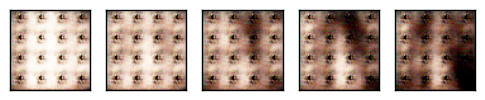

Step: 9220, critic loss: -5.87735947132
Step: 9240, critic loss: -5.77393208027
Step: 9260, critic loss: -5.61108425617


KeyboardInterrupt: 

In [32]:
%matplotlib inline

def avg(x): return sum(x) / float(len(x))

savecount = 0

last_step_printed = -1

losses = []

while True:
    examples_ = None
    step_ = global_step.eval()
    
    for _ in xrange(25 if step_ < 10 or step_ % 500 == 0 else 5):
        critic_loss_, _ = session.run([critic_loss, train_critic])
        losses.append(critic_loss_)
    
    session.run(train_gen)
    
    if step_ % 20 == 0:
        print "Step: {}, critic loss: {}".format(step_, avg(losses))
        losses = []
            
        examples_ = session.run(examples[:5])
        
        if step_ % 100 == 0:
            imshow_multi(list(examples_))
        
        if step_ % 200 == 0 and saver:
            should_save = True
            if should_save:
                saver.save(session, save_path + '/model.ckpt', global_step=step_rounded)
                print 'Saved'
                savecount += 1
                if savecount > 4:
                    create_session()
                    savecount = 0


In [ ]:
# debug:

fake_cond_vec_, real_cond_vec_, _ = session.run([fake_cond_vec, real_cond_vec, images_batch])
print fake_cond_vec_
print real_cond_vec_

In [ ]:
%matplotlib inline

examples_ = session.run(examples[:5])
imshow_multi(list(examples_))
